Fonction génération de graph pour le problème:

In [2]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt

def creation_graph(N):
    # Create a directed graph
    G = nx.DiGraph()
    N +=1

    # Add 20 nodes with status and color
    for i in range(1, N):
        status = random.choice([0, 1, 2])
        value = random.uniform(0, 1)
        color = 'red' if status == 0 else 'green' if status == 1 else 'blue'
        probability = 0
        if status == 2 :
            probability = random.uniform(0, 1)
        G.add_node(i, status=status, color=color, value=value, probability = probability)

    # Randomly assign weights to the edges such that the sum of weights going to each node is 1

    possible_targets = set(G.nodes())
    n = len(G.nodes())
    i = 0

    for node in G.nodes():
        # Generate random weights for outgoing edges
        i += 1
        if n != i :
            number_of_links = random.randint(1, n - i)
            outgoing_weights_1 = [random.uniform(0.1, 1) for _ in range(random.randint(1, n -i))]
            outgoing_weights_2 = [random.uniform(0.1, 1) for _ in range(random.randint(1, n -i))]

            # Remove the possibility of self-loops
            possible_targets = possible_targets - {node}

            targets = random.sample(possible_targets, number_of_links)

            # Add edges with weights
            for target, weight in zip(targets, outgoing_weights_1):
                G.add_edge(node, target, weight=weight)
            for target, weight in zip(targets, outgoing_weights_2):
                G.add_edge(target, node, weight=weight)

    sum_weight = [0.0 for i in range(1,N+1)]
    for k in range(1,N):
        for j in list(G.successors(k)):
            sum_weight[k] += G[k][j]["weight"]
        for j in list(G.successors(k)):
            G[k][j]["weight"] = G[k][j]["weight"]/sum_weight[k]

    return(G)

def show_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=0.5)  # Adjust the 'k' parameter for spread-out or more compact layout
    group_labels = {i: G.nodes[i]['status'] for i in G.nodes()}
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_colors, font_color='white', font_size=8, edge_color='gray', width=0.5, alpha=0.7)
    for edge, label in edge_labels.items():
        x = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
        y = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
        # Ajouter un petit décalage vertical pour éviter la superposition
        y += 0.05 if edge[0] < edge[1] else -0.05
        plt.text(x, y, label, fontsize=8, color='black', fontweight='bold', ha='center', va='center')

    nx.draw_networkx_labels(G, pos, labels=group_labels, font_size=9, font_color='black', font_weight='bold')

    # Display the plot
    plt.show()



def mat_A(G):
    N = len(G.nodes()) + 1
    A = np.zeros((N-1,N-1))
    S0_index = 0
    S2_index = 0
    for i in range(1,N):
        for j in range(1,N):
            if i != j :
                if G.nodes[i]['status'] == 0 :
                    S0_index = 1
                elif G.nodes[i]['status'] == 2 :
                    S2_index = 1
                else :
                    S0_index = 0
                    S2_index = 0
                if G.has_edge(i,j) :
                    A[i-1][j-1] = (1 - S0_index) * (1 - S2_index * G.nodes[i]['probability']) * G[i][j]['weight']
    return(A)

def w(u):
    n = u.shape[0]
    res = np.zeros((n,1))
    for k in range(n):
        res = 1 - np.exp(-u[k])
    return(res)

def dw(u):
  n = u.shape[0]
  res = np.zeros((n,1))
  for k in range(n):
      res = np.exp(-u[k])
  return(res)

def mat_H(G):
    N = len(G.nodes())
    H = np.zeros((N,1))
    for node in G.nodes():
        if G.nodes[node]['status'] == 0:
            H[node-1] = random.uniform(0, 1)
    return(H)

def mat_WS0(G):
    N = len(G.nodes()) + 1
    W = np.zeros((N-1,1))
    S0_index = 0
    H = mat_H(G)
    for i in range(1,N):
        if G.nodes[i]['status'] == 0 :
            S0_index = 1
        else :
            S0_index = 0
        W[i-1] = S0_index * H[i-1]
    return(W)

def mat_WS2(G):
    N = len(G.nodes()) + 1
    W = np.zeros((N-1,1))
    S2_index = 0
    for i in range(1,N):
        if G.nodes[i]['status'] == 2 :
            S2_index = 1
        else :
            S2_index = 0
        W[i-1] = S2_index * G.nodes[i]['probability']
    return(W)


Méthode par itération "manuelle"

Méthode du gradient

<ipython-input-2-5749729c7597>:38: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  targets = random.sample(possible_targets, number_of_links)


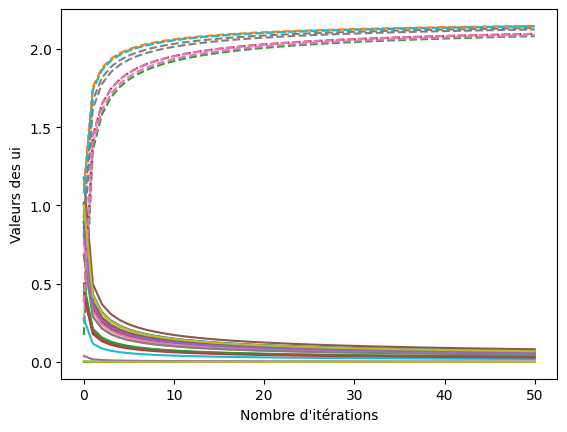

In [26]:
N = 30
M = 20
N_iter = 50


G = creation_graph(N)

A = mat_A(G)
Id = np.identity(N)
block_mat_inv = np.linalg.inv(Id - A)

vect_unit_T = np.zeros((1,N))
for k in range(N):
  vect_unit_T[0][k] = 1

U = np.zeros((N,1))
for k in range(N):
  U[k] = random.uniform(0, 2*M/N)
S = sum(U)
if  S > M :
  for k in range(N):
    U[k] = U[k]*M/S

Alpha = mat_WS2(G)

unit_t_Id_A_inv = np.dot(vect_unit_T, block_mat_inv)

index_S2 = []
for k in range(0,N):
  if G.nodes[k+1]['status'] == 2 :
    index_S2.append(k)

U_k = np.zeros((N,N_iter+1))

for k in range(1, N_iter+1):
  U_k[:,k-1] = np.transpose(U)[0]
  for i in index_S2:
    U[i] = U[i] + (1/k) * np.dot(unit_t_Id_A_inv, Alpha * dw(U_k[:,k-1]))
  S = sum(U)
  if  S > M :
    for k in range(N):
      U[k] = U[k]*M/S
U_k[:,N_iter] = np.transpose(U)[0]



for k in range(N):
  les_y = [x for x in U_k[k]]
  if k in index_S2 :
    plt.plot(les_y, label='controlled agents', linestyle='--')
  else:
    plt.plot(les_y, label='other agents')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Valeurs des ui")
plt.show()

Résolution par optimisation du problème : (Ca ne marche pas)

In [ ]:
import cvxpy as cp

N = 20
M = 18

G = creation_graph(N)
A = mat_A(G)
Id = np.identity(N)
I_S2 = np.zeros((N,1))
for node in G.nodes():
  if G.nodes[node]['status'] == 2:
    I_S2[node-1] = 1

U = cp.Variable((N,1), nonneg=True)

t_I_S2 = np.transpose(I_S2)
Inv = np.linalg.inv(Id - A)

mat_intermediaire_np = np.dot(t_I_S2, Inv)
mat_intermediaire_cp = cp.Parameter(mat_intermediaire_np.shape, value = mat_intermediaire_np)

mat_WS0_np = mat_WS0(G)
mat_WS0_cp = cp.Parameter(mat_WS0_np.shape, value = mat_WS0_np)

mat_WS2_np = mat_WS2(G)
mat_WS2_cp = cp.Parameter(mat_WS2_np.shape, value = mat_WS2_np)

mat_unit_np = np.zeros((N,1))
for k in range(N):
  mat_unit_np[k] = 1
mat_unit_cp = cp.Parameter(mat_unit_np.shape, value = mat_unit_np)

#The objective function must be on the param65 @ (param66 + -exp(var62)) form
#U_max = mat_intermediaire_cp@(mat_WS0_cp + cp.multiply(mat_WS2_cp, (mat_unit_cp - cp.exp(U))))
param66 = mat_WS0_cp + cp.multiply(mat_WS2_cp, mat_unit_cp)
U_max = mat_intermediaire_cp @ (param66 - cp.exp(cp.log(mat_WS2_cp) - cp.pos(U)))


obj = cp.Maximize(U_max)
constraint = [cp.sum(U) <= M]

prob = cp.Problem(obj, constraint)
prob.solve(solver=cp.SCS, max_iters=10000)
#prob.solve(solver=cp.ECOS, max_iters=10000)
#prob.solve(solver=cp.CVXOPT, max_iters=10000)
#prob.solve()
if prob.status != cp.OPTIMAL:
    raise Exception("Solver did not converge!")

print('U_sum {}'.format(prob.value))

U = U.value


<ipython-input-1-86c0a349b949>:38: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  targets = random.sample(possible_targets, number_of_links)


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
exp(log(param95) + -maximum(var92, 0.0))

IndexError: index 30 is out of bounds for axis 0 with size 30

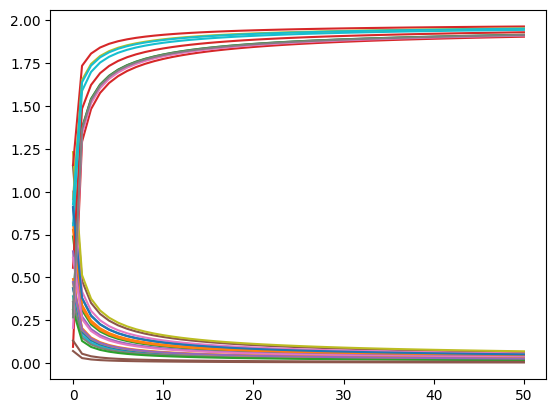

In [ ]:
U_k = np.zeros((10, 20))
print(U_k[0][:].shape)
print(U_k[:][0].shape)
U_k

(20,)
(20,)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])